In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# install OpenCV
!pip install opencv-python

# the usual ...
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

In [ ]:
from skimage.measure import  regionprops
from skimage.color import label2rgb
import matplotlib.patches as mpatches

In [ ]:
#@title Q4 Step 1 Functions
def Gauss1D(sigma, kernal_size):
  G = np.zeros(kernal_size)
  N = (kernal_size-1)/2
  if kernal_size % 2 == 0:
      print('kernel_size should be odd.')
  for i in range(kernal_size):
    G[i] = (1 / (sigma*np.sqrt(2*math.pi)))*np.exp(-(i-N)**2/(2*sigma**2))
  #normalize
  G = G/np.sum(G)
  return G

# Gaussion filter is a separable filter
def Gauss2D(sigma, kernal_size):
  G = np.zeros((kernal_size,kernal_size))
  gauss1d = Gauss1D(sigma,kernal_size);
    
  for i in range(kernal_size):
      for j in range(kernal_size):
          G[i,j] = gauss1d[i]*gauss1d[j]

  #normalize
  G = G/np.sum(G) 
  return G
  


In [ ]:
#@title Q4 Step 2 Functions
# Return new image with zero padding
# We use "same" padding here
def zeroPad(img, h_pad, w_pad):
  # zero matrix
  img_h,img_w = img.shape
  new_h = img_h + h_pad
  new_w = img_w + w_pad
  new_img = np.zeros((new_h, new_w), 'uint8')

  # copy orginal image into new_img with zero padding
  n = 0
  for i in range(h_pad//2, new_h - h_pad//2):
      m = 0
      for j in range(w_pad//2, new_w - w_pad//2):
          new_img[i, j] = img[n, m]
          m = m + 1
      n = n + 1
  return new_img

def convolution(img, filter):
  # create grayscale image                        
  img_grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
  # flip filter
  flipped = filter[::-1,::-1]
  # get size of filter and grayscale image
  f_height, f_width = filter.shape
  img_height, img_width = img_grey.shape

  # the padding size is to add k-1 at each side
  h_padding = f_height- 1
  w_padding = f_width - 1
  # get new image with padding
  padded_img = zeroPad(img_grey, h_padding, w_padding)

  result_img = np.zeros((img_height, img_width))
  h,w = result_img.shape
  for i in range(h):
      for j in range(w):
          result_img[i, j] = getValue(padded_img, flipped, i, j)
  return result_img

def getValue(padded_img, filter, i, j):
  #i,j is the index of top left corner of image patch(padded_image)
  sum = 0
  f_h, f_w = filter.shape
  for h in range(f_h):
    #col_start is j：orginal mistake point!!!!!!!!!
    col_start = j
    for w in range(f_w):
      sum = sum + filter[h,w]*padded_img[i,col_start]
      col_start = col_start+1
    i = i+1
  return sum

def GradientMag(img):
  #img is denoised by gaussion filter
  sobelx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
  sobely = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
  gx = convolution(img, sobelx)
  gy = convolution(img, sobely)
  Gxy = np.sqrt(gx**2+gy**2)

  return Gxy


In [ ]:
#@title Q4 Step 3 Functions
def Threshold(grad_img):
  h,w = grad_img.shape
  sum = 0
  for k in range(h):
    for g in range(w):
      sum += grad_img[k,g]
  
  thres = sum/(h*w)
  prev_thres = thres
  new_thres = float('inf')
  while new_thres != prev_thres:
    #return 2 lists of pixels [[h1,w1],[h2,w2]]
    if new_thres == float('inf'):
      Lower,Upper = Classify(grad_img, prev_thres)
    else:
      Lower,Upper = Classify(grad_img, new_thres)
    mL = 0
    mH = 0
    for i in range(len(Lower)):
      a,b = Lower[i]
      mL += grad_img[a,b]
    mL = mL/len(Lower)
    for j in range(len(Upper)):
      a1,b1 = Upper[j]
      mH += grad_img[a1,b1]
    mH = mH/len(Upper)
    prev_thres = new_thres
    new_thres = (mL+mH)/2
    #print(new_thres)
  final_thres = new_thres
  black, white = Classify(grad_img, final_thres)
  edge_img = np.zeros((h,w))
  for h1 in range(h):
    for w1 in range(w):
      if grad_img[h1,w1]>= final_thres:
        edge_img[h1,w1] = 255

  return edge_img

def Classify(grad_img, thres):
  Lower = []
  Upper = []
  h,w = grad_img.shape
  for i in range(h):
    for j in range(w):
      if grad_img[i,j]< thres:
        Lower.append([i,j])
      else:
        Upper.append([i,j])
  return Lower, Upper
  


In [ ]:
#@title Q5 Functions
def CCL(img):
  #img should be a binary img
  h,w = img.shape
  #0 means one pixel is not labelled
  label_img = np.zeros((h,w))

  curr_label = 1
  queue = []
  for i in range(h):
    for j in range(w):  
      if img[i,j] == 255 and label_img[i,j] == 0:
        label_img[i,j] = curr_label
        queue.insert(0, [i,j])
        while len(queue) != 0:
          index_i, index_j = queue.pop(0)
          #get a list of indexes for 8-neighbours that need to be labelled( foreground pixel and not labelled)
          component_list = GetComponent(img,label_img, index_i, index_j)
          #label the pixel before putting into the queue
          for elem in component_list:
            label_img[elem[0],elem[1]] = curr_label
          queue.extend(component_list)
        curr_label += 1
      #else, increment i or j 

  return label_img

def GetComponent(img, label_img, i, j):
  #get a list of indexes for 8-neighbours that need to be labelled( foreground pixel and not labelled)
  result = []
  h,w = img.shape
  # there are 8 different senarios
  if (i == 0 and j==0):
    for r1 in range(i,i+2):
      for c1 in range(j,j+2):
        if img[r1,c1]==255 and label_img[r1,c1] == 0:
          result.append([r1,c1])
  elif (i==0 and j==w-1):
    for r2 in range(i,i+2):
      for c2 in range(j-1,j+1):
        if img[r2,c2]==255 and label_img[r2,c2] == 0:
          result.append([r2,c2])
  elif (i==h-1 and j==0):
    for r3 in range(i-1,i+1):
      for c3 in range(j,j+2):
        if img[r3,c3]==255 and label_img[r3,c3] == 0:
          result.append([r3,c3])
  elif (i==h-1 and j==w-1):
    for r4 in range(i-1,i+1):
      for c4 in range(j-1,j+1):
        if img[r4,c4]==255 and label_img[r4,c4] == 0:
          result.append([r4,c4])
  elif (i == 0):
    for r5 in range(i,i+2):
      for c5 in range(j-1,j+2):
        if img[r5,c5]==255 and label_img[r5,c5] == 0:
          result.append([r5,c5])
  elif (i == h-1):
    for r6 in range(i-1,i+1):
      for c6 in range(j-1,j+2):
        if img[r6,c6]==255 and label_img[r6,c6] == 0:
          result.append([r6,c6])
  elif (j == 0):
    for r7 in range(i-1,i+2):
      for c7 in range(j,j+2):
        if img[r7,c7]==255 and label_img[r7,c7] == 0:
          result.append([r7,c7])
  elif (j == w-1):
    for r8 in range(i-1,i+2):
      for c8 in range(j-1,j+1):
        if img[r8,c8]==255 and label_img[r8,c8] == 0:
          result.append([r8,c8])
  else:
    for row in range(i -1, i + 2):
      for col in range(j-1, j + 2):
        if img[row,col]==255 and label_img[row,col] == 0:
          result.append([row,col])
  return result

In [ ]:
#@title Q6 Function 
def CountCell(label_img):
  # give color to labelled image
  image_label_overlay = label2rgb(label_img, image=img, bg_label=0)  
  #plt.imshow(image_label_overlay)
  fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(image_label_overlay)

  for region in regionprops(label_img.astype('uint8')): #need to be interger when drawing regions
      # take regions with large enough areas
      if region.area >= 40:
          # draw rectangle around segmented coins
          minr, minc, maxr, maxc = region.bbox
          rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                    fill=False, edgecolor='red', linewidth=2)
          ax.add_patch(rect)

  ax.set_axis_off()
  plt.tight_layout()
  plt.show()



In [ ]:
# read an image (make sure CavePainting.jpg is in the main folder in your Google Drive)
img = cv2.imread('/content/drive/My Drive/Colab Notebooks/Q4_image_1.jpg') # READS IN NUMPY ARRAY


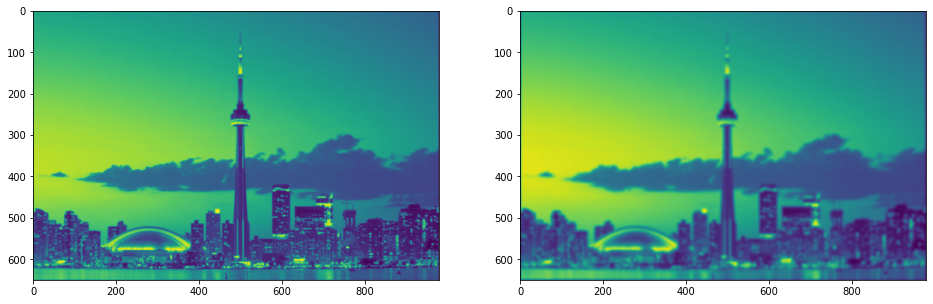

In [ ]:
#Q4 Step 1  (3,19)
kernel1 = Gauss2D(1, 7)
kernel2 = Gauss2D(3, 19)
#kernel3 = Gauss2D(2, 13)


dst = convolution(img,kernel1)
dst2 = convolution(img,kernel2)
dst_list = [dst,dst2]
#plot the figure
fig=plt.figure(figsize=(16, 16))
columns = 2
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(dst_list[i-1],cmap='gray')


In [ ]:
#Q4 Step 2
# we choose the kernel size in dst from previous step
denoised_img = dst
grad_mag = GradientMag(denoised_img)
plt.imshow(grad_mag,cmap = 'gray')

In [ ]:
#Q4 Step 3
edge_img = Threshold(grad_mag)
plt.imshow(edge_img,cmap = 'gray')

In [ ]:
#Q5 
label_img = CCL(edge_img)
print("The largest label is:", np.max(label_img))
#plt.imshow(label_img,cmap = 'gray')

In [ ]:
#Q6
CountCell(label_img)